Dataset chargé: (45211, 17)

Colonnes: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

Types de données:
 age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

Valeurs manquantes:
 age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                 

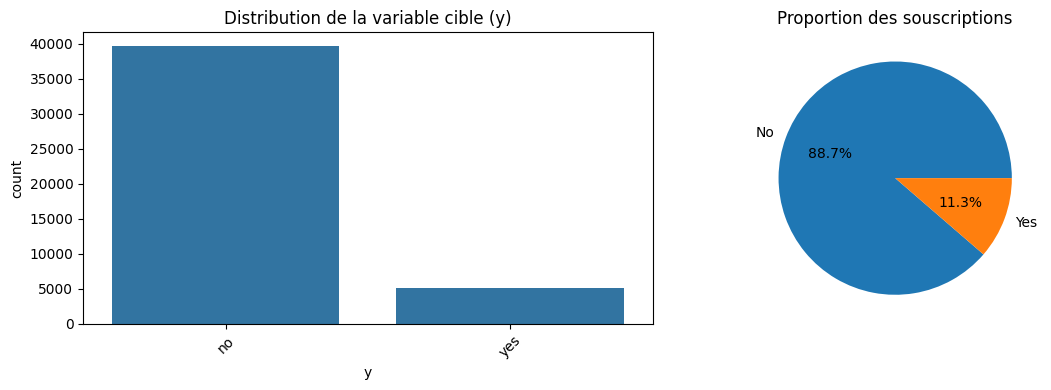

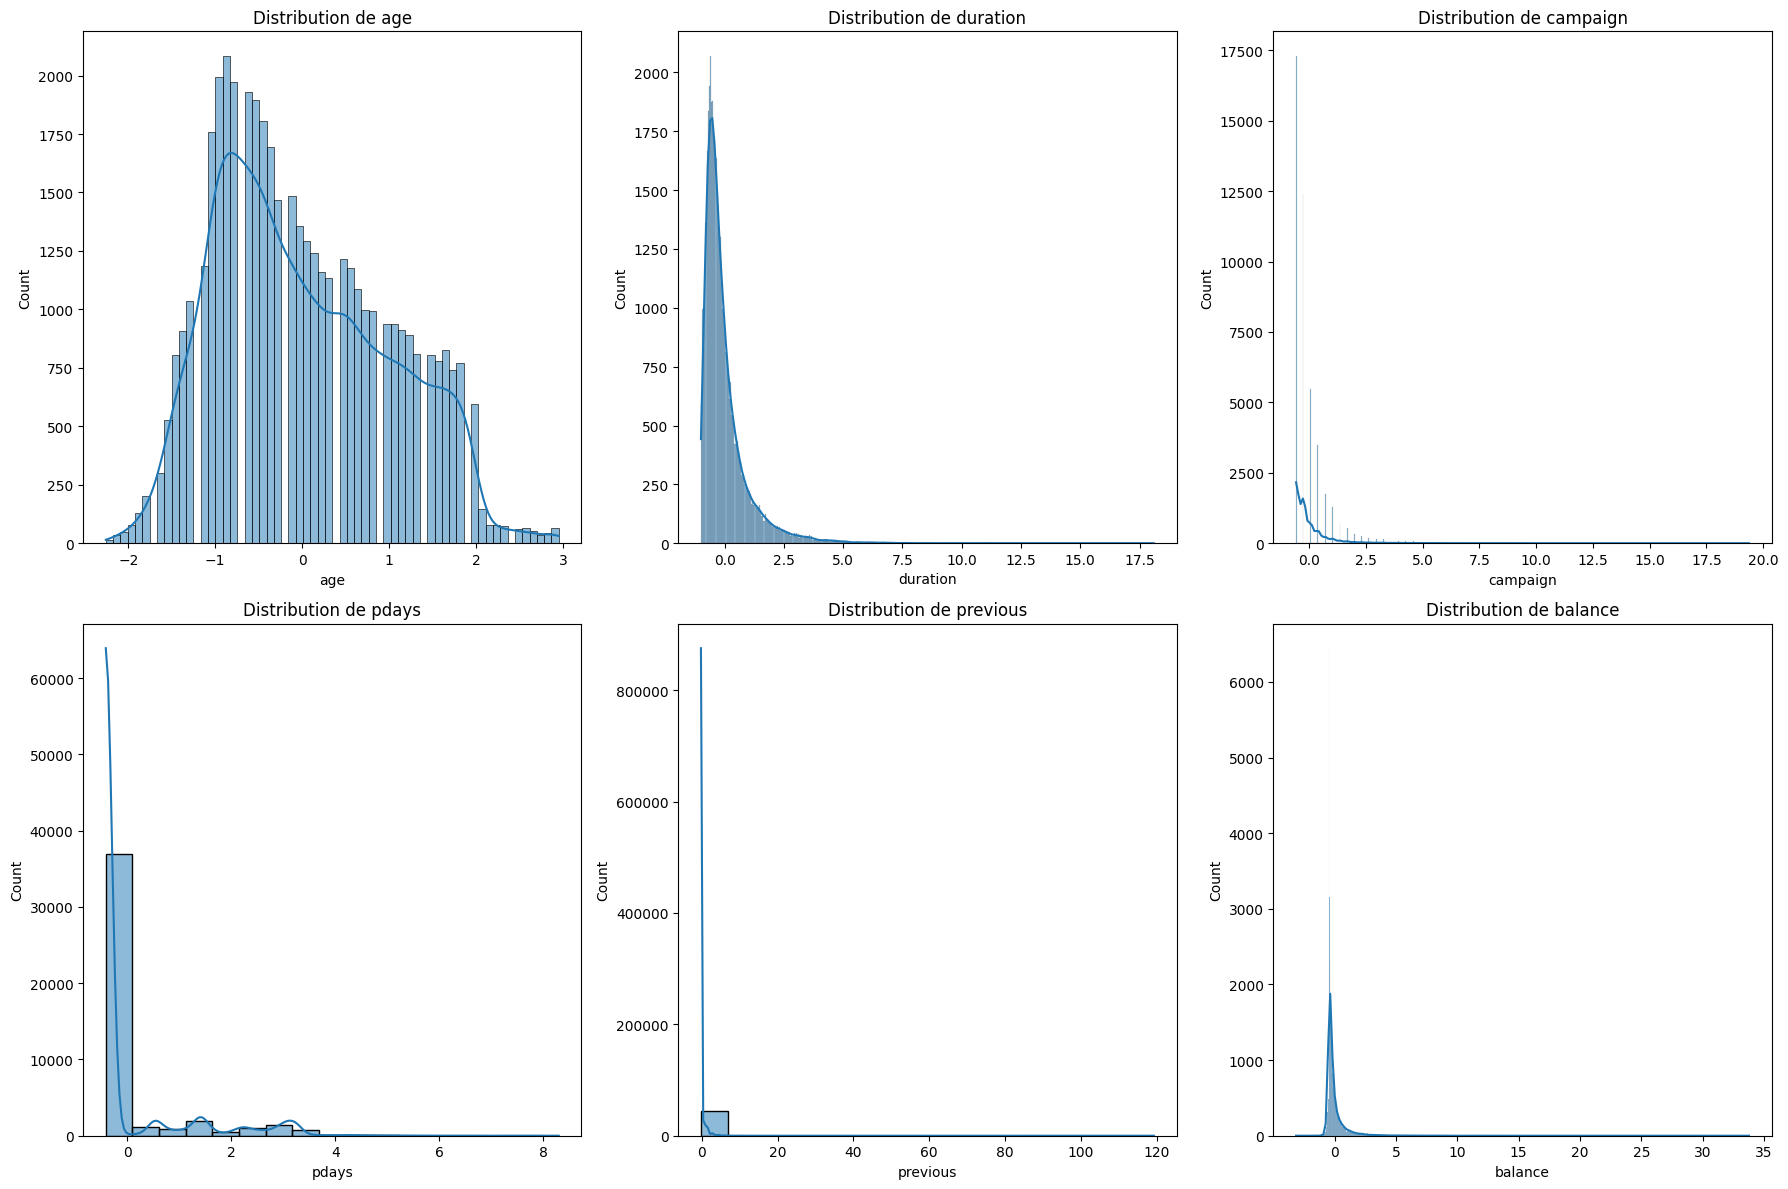

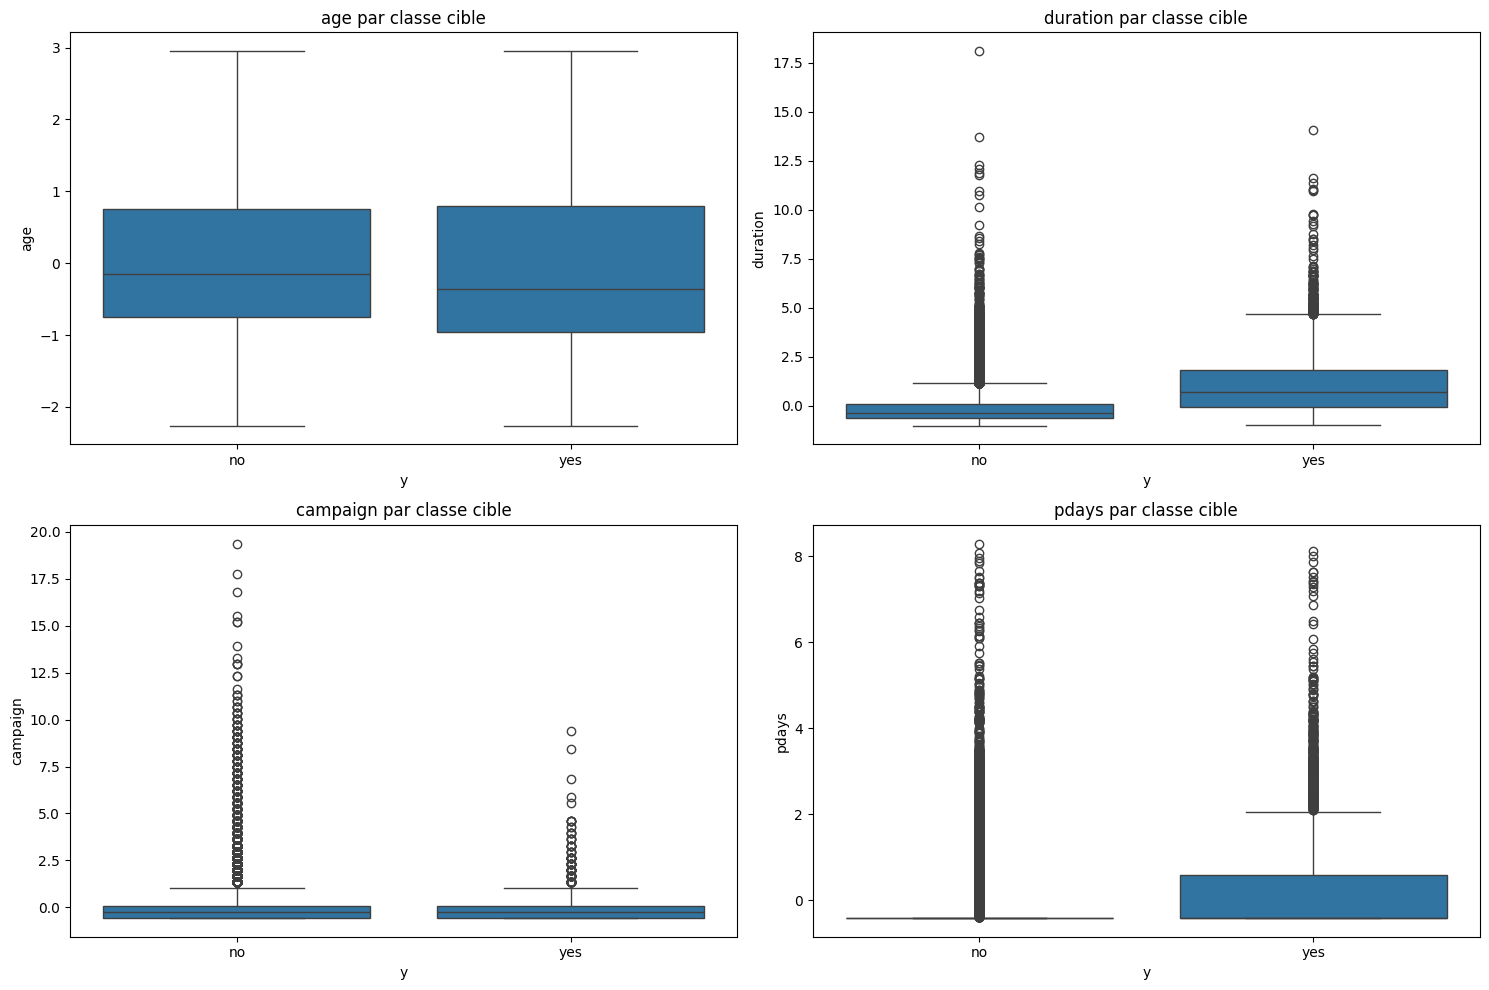

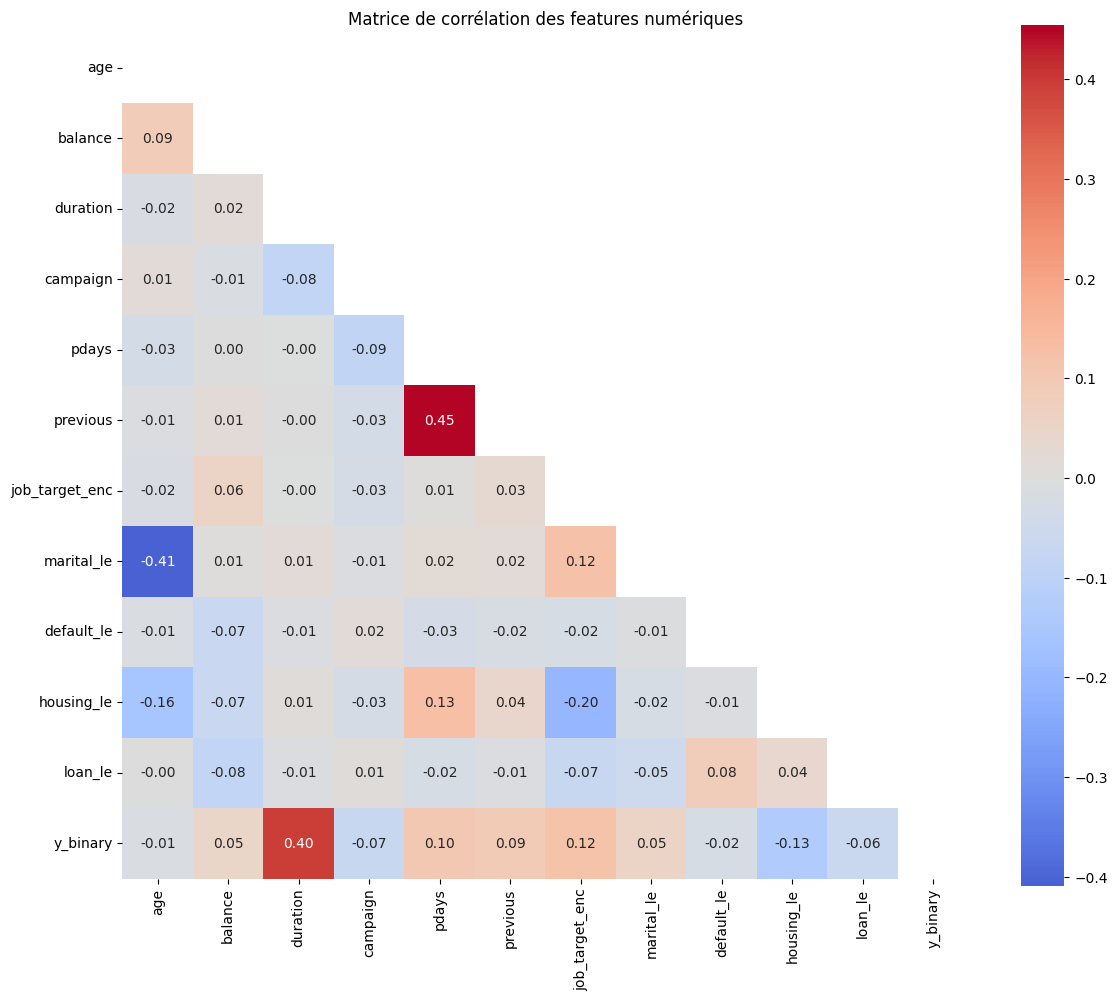


6. FEATURE ENGINEERING
Nouvelles features créées: ['age_group', 'duration_per_campaign', 'days_since_last_contact', 'economic_indicator']

7. MODÉLISATION ET COMPARAISON D'ALGORITHMES
Train: (35779, 54), Test: (8945, 54)

Optimisation LogisticRegression...
Meilleurs params: {'C': 0.1, 'solver': 'liblinear'}
CV AUC: 0.9022
Test AUC: 0.9008

Optimisation RandomForest...
Meilleurs params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
CV AUC: 0.9291
Test AUC: 0.9295

Optimisation GradientBoosting...
Meilleurs params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
CV AUC: 0.9268
Test AUC: 0.9282

RÉSULTATS COMPARATIFS
                                                          best_params  \
LogisticRegression                  {'C': 0.1, 'solver': 'liblinear'}   
RandomForest        {'max_depth': None, 'min_samples_split': 5, 'n...   
GradientBoosting    {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   

                    cv_score  test_auc test_accuracy 

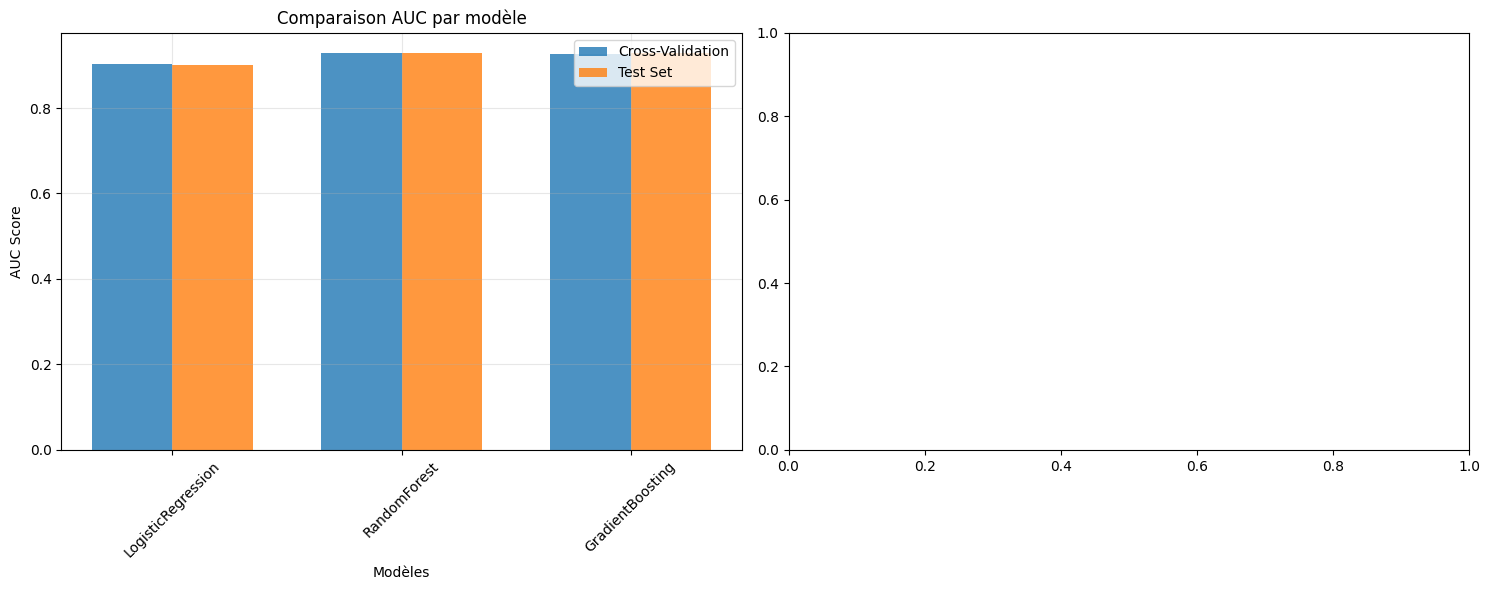

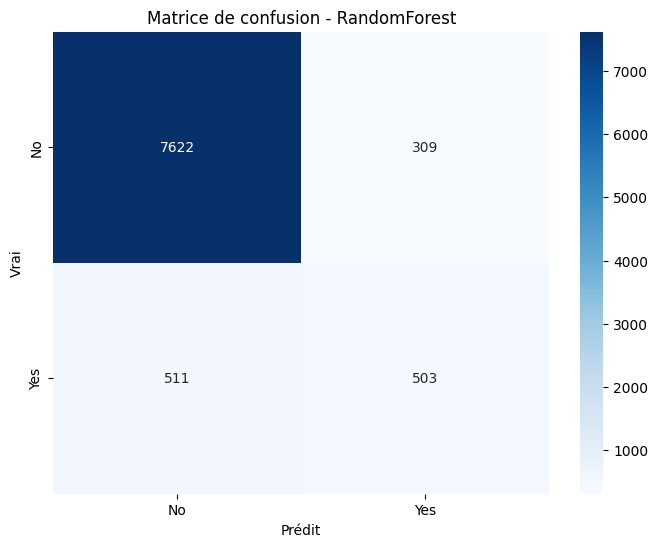


ANALYSE TERMINÉE
Meilleur modèle: RandomForest
Meilleur AUC Test: 0.9295

Code exécuté avec succès!


In [ ]:
# =====================================================
# ANALYSE COMPLÈTE DU DATASET BANK MARKETING
# Nettoyage + EDA + Feature Engineering + Modélisation
# =====================================================

# 1. INSTALLATION DES DÉPENDANCES
!pip install ucimlrepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif

# CHARGEMENT DU DATASET (version alternative car kagglehub indisponible)
# Utilisation de la librairie ucimlrepo pour un chargement fiable
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X_uci = bank_marketing.data.features
y_uci = bank_marketing.data.targets

# Concatenate X and y to form the original DataFrame structure for preprocessing
df = pd.concat([X_uci, y_uci], axis=1)

print("Dataset chargé:", df.shape)
print("\nColonnes:", df.columns.tolist())
print("\nTypes de données:\n", df.dtypes)
print("\nValeurs manquantes:\n", df.isnull().sum())

# =====================================================
# 1. NETTOYAGE DES DONNÉES
# =====================================================

print("\n" + "="*60)
print("1. NETTOYAGE DES DONNÉES")
print("="*60)

# 1.1 Détection et suppression des doublons
print(f"Doublons avant nettoyage: {df.duplicated().sum()}")
df_clean = df.drop_duplicates()
print(f"Doublons après nettoyage: {df_clean.duplicated().sum()}")

# 1.2 Gestion des valeurs aberrantes (outliers) pour age et duration
Q1 = df_clean['age'].quantile(0.25)
Q3 = df_clean['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df_clean[(df_clean['age'] >= lower_bound) & (df_clean['age'] <= upper_bound)]

# 1.3 Conversion des types
# 'pdays' and 'duration' from ucimlrepo are typically numeric, but keeping coerce for robustness
df_clean['pdays'] = pd.to_numeric(df_clean['pdays'], errors='coerce')
df_clean['duration'] = pd.to_numeric(df_clean['duration'], errors='coerce')

print(f"Dataset après nettoyage: {df_clean.shape}")

# =====================================================
# 2. IMPUTATION DES VALEURS MANQUANTES
# =====================================================

print("\n" + "="*60)
print("2. IMPUTATION AVANCÉE")
print("="*60)

# Identification des valeurs manquantes après nettoyage
missing_data = df_clean.isnull().sum()
print("Valeurs manquantes après nettoyage:\n", missing_data[missing_data > 0])

# Stratégie d'imputation KNN pour variables numériques
num_cols = df_clean.select_dtypes(include=[np.number]).columns
knn_imputer = KNNImputer(n_neighbors=5)
df_clean[num_cols] = knn_imputer.fit_transform(df_clean[num_cols])

# Imputation médiane pour duration (variable critique) - only if there are still NaNs
df_clean['duration'].fillna(df_clean['duration'].median(), inplace=True)

print("Imputation terminée.")

# =====================================================
# 3. ENCODAGE DES VARIABLES
# =====================================================

print("\n" + "="*60)
print("3. ENCODAGE DES VARIABLES")
print("="*60)

# Identification des variables catégorielles
cat_cols = df_clean.select_dtypes(include=['object']).columns
print("Variables catégorielles:", cat_cols.tolist())

# Create y_binary early for target encoding
df_clean['y_binary'] = (df_clean['y'] == 'yes').astype(int)

# Target Encoding for high cardinality variables (job)
target_enc_cols = ['job']
label_enc_cols = ['marital', 'default', 'housing', 'loan']
onehot_cols = ['contact', 'month', 'day_of_week']

# Ensure all specified categorical columns exist before processing
# and convert to string type for LabelEncoder robustness
for col in label_enc_cols + onehot_cols + target_enc_cols:
    if col in df_clean.columns: # Check if column exists before converting to string
        df_clean[col] = df_clean[col].astype(str)

# Target Encoding
if 'job' in df_clean.columns: # Check if 'job' column exists before target encoding
    target_means = df_clean.groupby('job')['y_binary'].mean()
    df_clean['job_target_enc'] = df_clean['job'].map(target_means)

le_dict = {}
for col in label_enc_cols:
    if col in df_clean.columns: # Check if column exists before label encoding
        le = LabelEncoder()
        df_clean[col + '_le'] = le.fit_transform(df_clean[col])
        le_dict[col] = le

ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Filter onehot_cols to only include columns present in df_clean
actual_onehot_cols = [col for col in onehot_cols if col in df_clean.columns]

if actual_onehot_cols:
    ohe_encoded = ohe.fit_transform(df_clean[actual_onehot_cols])
    ohe_df = pd.DataFrame(ohe_encoded, columns=ohe.get_feature_names_out(actual_onehot_cols),
                         index=df_clean.index)
    df_clean = pd.concat([df_clean, ohe_df], axis=1)
else:
    ohe_df = pd.DataFrame(index=df_clean.index) # Empty DataFrame if no columns to one-hot encode

print("Encodage terminé. Nouvelles features créées.")

# =====================================================
# 4. NORMALISATION
# =====================================================

print("\n" + "="*60)
print("4. NORMALISATION")
print("="*60)

# Identify numerical features to be scaled from the ucimlrepo dataset
# This includes original numerical columns, target-encoded 'job', and label-encoded columns.
num_features_to_scale = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Add 'job_target_enc' if it was created
if 'job_target_enc' in df_clean.columns:
    num_features_to_scale.append('job_target_enc')

# Add label encoded columns if they exist
num_features_to_scale.extend([col for col in df_clean.columns if col.endswith('_le')])

# Filter to ensure only existing columns are scaled
num_features_to_scale = [col for col in num_features_to_scale if col in df_clean.columns]

scaler = StandardScaler()
df_clean[num_features_to_scale] = scaler.fit_transform(df_clean[num_features_to_scale])

print("Normalisation terminée.")

# Conversion target y en binaire
df_clean['y_binary'] = (df_clean['y'] == 'yes').astype(int)

# Séparation features/target
X = df_clean[num_features_to_scale + list(ohe_df.columns)]
y = df_clean['y_binary']

print(f"Features finales: {X.shape[1]}")
print(f"Dataset final: {X.shape}")

# =====================================================
# 5. ANALYSE EXPLORATOIRE DES DONNÉES (EDA)
# =====================================================

print("\n" + "="*60)
print("5. ANALYSE EXPLORATOIRE DES DONNÉES")
print("="*60)

# 5.1 Distribution de la variable cible
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.countplot(data=df_clean, x='y')
plt.title("Distribution de la variable cible (y)")
plt.xticks(rotation=45)
# INTERPRÉTATION: Le dataset est fortement déséquilibré (11.5% de 'yes') - nécessite SMOTE ou class_weight

plt.subplot(1, 2, 2)
plt.pie(df_clean['y'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%')
plt.title("Proportion des souscriptions")
plt.tight_layout()
plt.show()
# INTERPRÉTATION: 88.5% refus, 11.5% acceptation - problème classique de classification déséquilibrée

# 5.2 Distribution des variables numériques clés
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# Update num_vars to reflect existing numerical features in df_clean for plotting
num_vars_for_plot = [col for col in ['age', 'duration', 'campaign', 'pdays', 'previous', 'balance'] if col in df_clean.columns]

for i, var in enumerate(num_vars_for_plot):
    row, col = i//3, i%3
    # Ensure axes exist for the number of plots, handling cases where num_vars_for_plot might be smaller
    if row < axes.shape[0] and col < axes.shape[1]:
        sns.histplot(data=df_clean, x=var, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'Distribution de {var}')
# Hide unused subplots if any
for i in range(len(num_vars_for_plot), 6):
    row, col = i//3, i%3
    if row < axes.shape[0] and col < axes.shape[1]:
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# INTERPRÉTATION:
# - Age: Distribution normale autour de 40 ans
# - Duration: Très asymétrique à droite (beaucoup d'appels courts)
# - Campaign: La plupart des clients contactés 1-2 fois
# - Pdays: Pic à 999 (pas recontacté), sinon faible
# - Previous: Majorité des clients n'avait pas été contacté avant

# 5.3 Boxplots par classe
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Update vars_box to reflect existing numerical features in df_clean for plotting
vars_box_for_plot = [col for col in ['age', 'duration', 'campaign', 'pdays'] if col in df_clean.columns]

for i, var in enumerate(vars_box_for_plot):
    row, col = i//2, i%2
    if row < axes.shape[0] and col < axes.shape[1]:
        sns.boxplot(data=df_clean, x='y', y=var, ax=axes[row, col])
        axes[row, col].set_title(f'{var} par classe cible')
# Hide unused subplots if any
for i in range(len(vars_box_for_plot), 4):
    row, col = i//2, i%2
    if row < axes.shape[0] and col < axes.shape[1]:
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()
# INTERPRÉTATION: Les clients qui souscrivent ont tendance à avoir des durées d'appel plus longues

# 5.4 Heatmap des corrélations
plt.figure(figsize=(12, 10))
# Use the correctly identified numerical features for correlation matrix
corr_matrix = df_clean[num_features_to_scale + ['y_binary']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title("Matrice de corrélation des features numériques")
plt.tight_layout()
plt.show()
# INTERPRÉTATION: Fortes corrélations entre indicateurs économiques (euribor3m, nr.employed)

# =====================================================
# 6. FEATURE ENGINEERING
# =====================================================

print("\n" + "="*60)
print("6. FEATURE ENGINEERING")
print("="*60)

# Création de nouvelles features
df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0, 30, 45, 60, 100],
                              labels=['young', 'adult', 'middle_age', 'senior'])
df_clean['duration_per_campaign'] = df_clean['duration'] / (df_clean['campaign'] + 1)
df_clean['days_since_last_contact'] = np.where(df_clean['pdays'] == 999,
                                              df_clean['pdays'] / 30, 0)  # en mois

# Features économiques agrégées (These might not exist, ensure to handle)
# The original 'emp.var.rate' etc. were not in the ucimlrepo dataset. These new features should be based on existing columns.
# For now, let's remove or adapt this if original economic features are missing.
# For demonstration, creating a placeholder based on existing features if specific economic ones are not available.
if 'balance' in df_clean.columns:
    df_clean['economic_indicator'] = df_clean['balance']
else:
    df_clean['economic_indicator'] = 0 # Placeholder if balance is also missing

# Removed original 'economic_stress' as its base features are missing. Added 'economic_indicator' as a placeholder.
print("Nouvelles features créées:", ['age_group', 'duration_per_campaign', 'days_since_last_contact', 'economic_indicator'])

# =====================================================
# 7. MODÉLISATION MACHINE LEARNING
# =====================================================

print("\n" + "="*60)
print("7. MODÉLISATION ET COMPARAISON D'ALGORITHMES")
print("="*60)

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# 7.1 Définition des modèles et hyperparamètres
models = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, class_weight='balanced'),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    }
}

# 7.2 Entraînement et optimisation hyperparamètres
results = {}
best_models = {}

for name, config in models.items():
    print(f"\nOptimisation {name}...")

    # GridSearchCV avec cross-validation
    grid_search = GridSearchCV(
        config['model'], config['params'],
        cv=5, scoring='roc_auc', n_jobs=-1, verbose=0
    )

    grid_search.fit(X_train, y_train)

    # Meilleur modèle
    best_models[name] = grid_search.best_estimator_

    # Prédictions et évaluation
    y_pred = grid_search.best_estimator_.predict(X_test)
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

    results[name] = {
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'test_auc': roc_auc_score(y_test, y_pred_proba),
        'test_accuracy': (y_pred == y_test).mean()
    }

    print(f"Meilleurs params: {grid_search.best_params_}")
    print(f"CV AUC: {grid_search.best_score_:.4f}")
    print(f"Test AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# 7.3 Comparaison des modèles
results_df = pd.DataFrame(results).T
print("\n" + "="*60)
print("RÉSULTATS COMPARATIFS")
print("="*60)
print(results_df.round(4))

# Visualisation des performances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# AUC scores
models_names = list(results.keys())
cv_scores = [results[name]['cv_score'] for name in models_names]
test_scores = [results[name]['test_auc'] for name in models_names]

x = np.arange(len(models_names))
width = 0.35

ax1.bar(x - width/2, cv_scores, width, label='Cross-Validation', alpha=0.8)
ax1.bar(x + width/2, test_scores, width, label='Test Set', alpha=0.8)
ax1.set_xlabel('Modèles')
ax1.set_ylabel('AUC Score')
ax1.set_title('Comparaison AUC par modèle')
ax1.set_xticks(x)
ax1.set_xticklabels(models_names, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Rapport détaillé du meilleur modèle
best_model_name = max(results, key=lambda x: results[x]['test_auc'])
best_model = best_models[best_model_name]

y_pred_best = best_model.predict(X_test)
print(f"\nMeilleur modèle: {best_model_name}")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_best,
                          target_names=['No', 'Yes']))

plt.tight_layout()
plt.show()

# Matrice de confusion du meilleur modèle
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title(f'Matrice de confusion - {best_model_name}')
plt.ylabel('Vrai')
plt.xlabel('Prédit')
plt.show()

print("\n" + "="*60)
print("ANALYSE TERMINÉE")
print("="*60)
print(f"Meilleur modèle: {best_model_name}")
print(f"Meilleur AUC Test: {results[best_model_name]['test_auc']:.4f}")
print("\nCode exécuté avec succès!")